In [9]:
import os
import sys

cwd0 = "./config/"
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color

vID.init(cwd0)
import tools4pyPhysChem as t4pPC

**Start at:** Friday 03 November 2023, 22:36:23  
**Hostname:** vfornemo-server (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# <!-- TITLE --> MOLECULAR DYNAMICS - VELOCITY VERLET ALGORITHM

## Introduction

<div class="intro">

This computer lab deal with Classical molecular dynamics. In the context of theoretical chemistry, classical molecular dynamic is a computational method that allows study the motion of atoms or molecule under the influence of a specific potential. The principle of molecular dynamic is to solve Newton’s equations of motions in order to simulate the dynamical behaviour of nuclei.
    
The principle of classical molecular dynamics is to solve Newton's equations to model the dynamic behavior of nuclei. In order to calculate the positions of atoms at a given time, it is necessary to use a "propagator". Of the many propagators available, the "Velocity-Verlet" type is among the most widely used. In this case, positions and velocities are propagated over time according to the following equations.
\begin{align}    
\mathbf{x(t+\delta t)=x(t)+v_x(t).\delta t+\frac{1}{2} \gamma(t).\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_x(t+\delta t)=v_x(t)+\frac{\gamma(t)+\gamma(t+δt)}{2}.\delta t} \\
\end{align}
    
whith $v(t)$, the velocity (first derivatives of positions with respect to time) and $\gamma (t)$, the acceleration (second derivatives of positions with respect to time).
    
To determine accelerations, we use Newton's law, which relates acceleration to force and thus to the energy gradient.
    
\begin{align}
\vec{\gamma}(t) & = \frac{\vec{F}(t)}{M} \\
\end{align}
    
    
\begin{align}
\vec{F}(t)&=-\vec{\nabla}_x{\mathbf{V(x(t))}}&= -\frac{\partial V(x(t))}{\partial x} \\
\end{align}
    
Initial conditions ($x(t=0)$ and $v(t=0)$) and a potential function are therefore required to achieve dynamics. The propagation of positions and velocities is iterative. By rewriting the "velocity verlet" equations considering t=0, the positions and velocities calculated for δt will become the positions and velocities at t=0 for the next point and so on....
For this project, we'll consider a particle of mass 1 moving on a one-dimensional model potential (the generalisation to two- or more-dimension is straitforward)

</div>



## Definition of the differents potentials

<div class="rqT" title="Directives">
    
- It is necessary to define model potentials before performing MD simulations
- These potentials and the associated forces must be defined using symbolic algebra and may need the SymPy module
</div>


<u>One-dimensional model potentials considered</u>:
    
    
**Harmonic potential**: $$ V(x)=k.(x-x_e)^2 $$


**Morse Potential**: $$V(x)=D_e.(1-e^{-\alpha(x-x_e)})^2$$


**Double_well potential**: $$ V(x)=\frac{1}{2}(f_1(x)+f_2(x))-\frac{1}{2}\sqrt{(f_1(x)-f_2(x))^2+h^2} $$

with $$ f_i(x)=k_i.(x-x_{ei})^2 + V_i $$

    



In [10]:
import sympy as sym
import math
import numpy as np
import matplotlib.pyplot as plt

<div class="rqT" title="Directives">
    
- Each potential can be characterized by several parameters, which need to be defined beforehand. 
</div>

In [11]:
#Define parameters for potentials:
m = 1       # mass of the particle
xe_1 = 0    # Equilibrium distance for harmonic, Morse and double well potentials
xe_2 = -2   # Equilibrium distance for double well potential only

k_1 =  2    # Force constant for harmonic and double well potentials
k_2 =  2    # Force constant for double well potential only

alpha = 0.05     # Parameter for Morse potentia
De = 2           # Prefactor for Morse potential

V_1 =  0      # Translation of potential (1) for double well potential
V_2 =  0      # Translation of potential (2) for double well potential

h = 2         # Coupling term for double well potential

<div class="exE">

- To simplify the switch between potentials, define three differents function as a function of x, one for each potential
- <b/>Forces</b> are a point of utmost importance of the algorithm. Define a function to calculate forces for a selected potential
- Display the analytic expression of the selected potential and associated forces
- Plot the selected potential as a function of the variable 'x' (You may need to use the lambdify function in the SymPy module to calculate a numerical value). 
    
</div>

Harmonic Potential


2*x**2

-4*x

Morse Potential


2*(1 - exp(-0.05*x))**2

-0.2*(1 - exp(-0.05*x))*exp(-0.05*x)

Double Well Potential


1.0*x**2 + 1.0*(x + 2)**2 - 0.5*sqrt((2*x**2 - 2*(x + 2)**2)**2 + 4)

-4.0*x + 0.5*(-16*x**2 + 16*(x + 2)**2)/sqrt((2*x**2 - 2*(x + 2)**2)**2 + 4) - 4.0

Text(0.5, 0, '$V$')

Text(0.5, 0, '$x$')

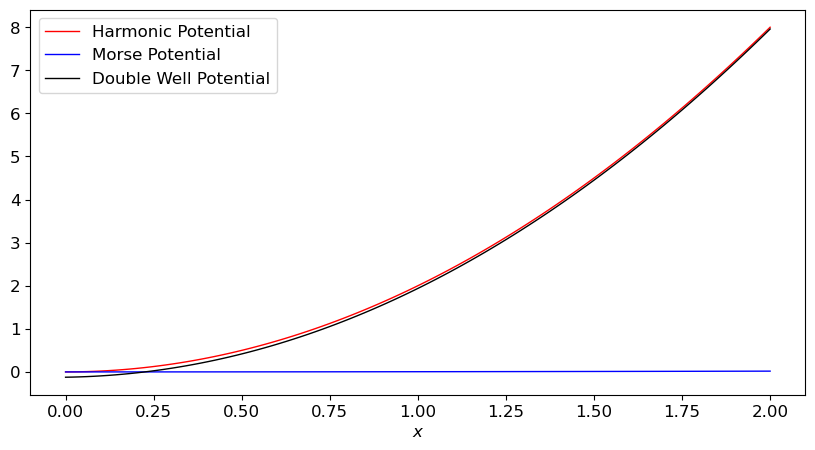

In [48]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sympy import Symbol
import matplotlib.pyplot as plt

# Define potentials
def har_V(x):
    v = k_1*(x-xe_1)**2
    return v

def morse_V(x):
    if isinstance(x, Symbol):
        v = De*(1-sym.exp(-alpha*(x-xe_1)))**2
    else:
        v = De*(1-math.exp(-alpha*(x-xe_1)))**2
    return v
    
def dbwl_V(x):
    f1 = k_1*(x-xe_1)**2 + V_1
    f2 = k_2*(x-xe_2)**2 + V_2
    if isinstance(x, Symbol):
        v = .5*(f1+f2) - .5*sym.sqrt((f1-f2)**2 + h**2)
    else:
        v = .5*(f1+f2) - .5*math.sqrt((f1-f2)**2 + h**2)
    return v

# Define force
def force_expr(V_type):
    '''
    V_type: int, type of potential
        default: harmonic potential
        1: morse potential
        2: double well potential
    
    return:
        the expression of force by the given potential
    '''
    if V_type == 1:
        method = morse_V
    elif V_type == 2:
        method = dbwl_V
    else:
        method = har_V
    
    x = sym.symbols("x")
    V = method(x)
    f = -sym.diff(V,x)
    
    return f
    
# Display expressions
# Harmonic
print("Harmonic Potential")
x = sym.symbols("x")
V0 = har_V(x)
f0 = force_expr(0)
V0
f0

# Morse
print("Morse Potential")
V1 = morse_V(x)
f1 = force_expr(1)
V1
f1

# Double well
print("Double Well Potential")
V2 = dbwl_V(x)
f2 = force_expr(2)
V2
f2

# Plot
_x = np.linspace(0.,2.,100)
_V0 = sym.lambdify([x],v0) 
_V1 = sym.lambdify([x],v1) 
_V2 = sym.lambdify([x],v2) 

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 12})
plt.plot(_x, _V0(_x),linewidth=1,color='red',label="Harmonic Potential")
plt.plot(_x, _V1(_x),linewidth=1,color='blue',label="Morse Potential")
plt.plot(_x, _V2(_x),linewidth=1,color='black',label="Double Well Potential")
plt.xlabel("$V$")
plt.xlabel("$x$")
plt.legend()
plt.show()


## Velocity Verlet Algorithm

<div class="rqT" title="Directives">
    
- Several parameters must be defined to control the MD simulation:
    - step time <b/> δt</b>     
    - Total time or number of steps 
    - The initial position and initial velocity
- <b/>Total energy</b>, defined in the context of Hamiltonian mechanics, is a constant. It must be calculated for each time step in order to check that the algorithm behaves correctly. 
- You will need to use the lambdify function in the SymPy module to calculate a numerical force value for each position.  

</div>

<div class="exE">

- Define the variables that describe the parameters of the MD simulation (initial time will be set to 0)
- Use a loop to implement the velocity verlet algorithm
    - Defining functions for updating positions and speeds can be useful but is not mandatory
- For each step (including the initial step), record in separate tables (or in a single file)
    - Time
    - Position
    - Velocity
    - Energy (i.e value of the potential)
    - Total energy
    
    
</div>

In [65]:
import csv 

# Define variables
t_step = 0.1  # step time
t_init = 0 # initial time
t_tot = 10 # total time
step_tot = 10 # total step
x_init = 0 # initial position
vx_init = 0 # initial velocity
E_tot = 0 # total energy
M = 1 # particle mass

# Define force
def force(pos, V_method):
    '''
    pos: current position of particle
    V_method: potential method
        
    return:
        the value of force by the given potential
    '''
    x_sym = sym.symbols("x")
    V = V_method(x_sym)
    f = -sym.diff(V,x_sym)
    _f = sym.lambdify([x_sym],f) 
    return _f(pos)

def pos_iter(t_step, pos, spd, V_method):
    f = force(pos, V_method)
    a = f/M # acceleration
    pos_new = pos + spd*t_step + 0.5*a*t_step**2
    return pos_new
    
def spd_iter(t_step, pos, pos_new, spd, V_method):
    f0 = force(pos, V_method)
    f1 = force(pos_new, V_method)
    a0 = f0/M # acceleration when t
    a1 = f1/M # acceleration when t+δt
    spd_new = spd + 0.5*(a0+a1)*t_step
    return spd_new

def dynamics(t_step, t_init, t_tot, step_tot, x_init, vx_init, E_tot, M, V_type):
    '''
    Perform molecular dynamics
    
    input: 
    t_step:   step time
    t_init:   initial time
    t_tot:    total time
    step_tot: total step
    x_init:   initial position
    vx_init:  initial velocity
    E_tot:    total energy
    M:        particle mass
    V_type:   int, type of potential
              default: harmonic potential
              1: morse potential
              2: double well potential
    
    Data will be stored in md_log.csv
    '''
    
    f = open("md_log.csv", "a")
    writer = csv.writer(f)
    writer.writerow(["Step", "Time", "Position", "Velocity", "Energy", "Total energy"])
    
    threthold = 1e-3 # threthold for energy
    step_count = 0
    time_count = t_init
    pos = x_init
    spd = vx_init
    
    if V_type == 1:
        method = morse_V
    elif V_type == 2:
        method = dbwl_V
    else:
        method = har_V
    
    e_warning = False # Warning if energy deviates from the given value
    
    while (step_count < step_tot and time_count <= t_tot):
        pos_new = pos_iter(t_step, pos, spd, method)
        spd = spd_iter(t_step, pos, pos_new, spd, method)
        pos = pos_new
        V = method(pos)
        e_tot = 0.5*M*spd**2 + V
        time_count += t_step
        step_count += 1
        writer.writerow([step_count, time_count, pos, spd, V, e_tot])
        
        # Warning if total energy of the system not correspond to the given E_tot
        if abs(e_tot - E_tot) > threthold:
            e_warning = True
    
    if e_warning:
        print("Warning: total energy of system deviates from the given value.")
        
    print("Molecular Dynamics Complete!")
    f.close() 
    
dynamics(t_step, t_init, t_tot, step_tot, x_init, vx_init, E_tot, M, 0)


Molecular Dynamics Complete!


## Post processing

<div class="rqT" title="Directives">
    
- The advantage of MD simulation is that several parameters are stored (in tables or files) and can be used for post-processing
    
    - To check the validity of the algorithm
    - To calculate mean structural or spectroscopic properties

</div>

<div class="exE">

- To check the validity of the algorithm
    - Plot the stored potentials as a function of stored positions 
    - Plot the stored positions or velocities as a function of time
    - Plot the variation in total energy (as a percentage) as a function of time
- To calculate mean structural or spectroscopic properties
    - Calculate the mean value of the position
    
    
</div>

In [ ]:
# insert your code here


## OPTIONNAL :Beyond the potential of one dimension - 2D potentials

<div class="rqT" title="Directives">
    
- A two-dimensional potential can simply be created by adding a one-dimensional potential along x and another along y, as well as any coupling function between x and y.
    
 $$ V(x,y)=V_1(x)+V_2(y)+f(x,y) $$
    
where $𝑉_1 (𝑥)$ and $𝑉_2 (𝑦)$ can be one of the previous potential and with, for example, $𝑓(𝑥,𝑦)=𝑥.𝑦$
    
Using a double-well potential for $𝑉_1 (𝑥)$ and $𝑉_2 (𝑦)$ and the coupling function define just before will creat a four-well potential.


- Another way to implement a two-dimensional potential is to use the so-called Muller-Brown potential:
   $$ V(x,y)=\sum_{i=1}^4 A_i.exp[a_i(x-x^0_i)^2+b_i(x-x^0_i)(y-y^0_i)+c_i(y-y^0_i)^2] $$
    
with

A = (−200, −100, −170, 15)
    
a = (−1, −1, −6.5, 0.7) ; b = (0, 0, 11, 0.6) ; c = (−10, −10, −6.5, 0.7)
    
$x^0$ = (1, 0, −0.5, −1) ; $y^0$ = (0, 0.5, 1.5, 1)
     
</div>

<div class="rqT" title="Directives">
    
- For the Velocity-Verlet algorithm, you will need to calculate new positions (new $x$ and new $y$) and speeds (new $v_x$ and new $v_y$) using the formula given at the beginning:

For $x$:
    
\begin{align}    
\mathbf{x(t+\delta t)=x(t)+v_x(t).\delta t-\frac{1}{2M}\frac{\partial V(x(t),y(t))}{\partial x}.\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_x(t+\delta t)=v_x(t)-\frac{1}{2M}[\frac{\partial V(x(t),y(t))}{\partial x}+\frac{\partial V(x(t+\delta t),y(t+\delta t))}{\partial x}].\delta t} \\
\end{align}
    
For $y$:
    
\begin{align}    
\mathbf{y(t+\delta t)=y(t)+v_y(t).\delta t-\frac{1}{2M}\frac{\partial V(x(t),y(t))}{\partial y}.\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_y(t+\delta t)=v_y(t)-\frac{1}{2M}[\frac{\partial V(x(t),y(t))}{\partial y}+\frac{\partial V(x(t+\delta t),y(t+\delta t))}{\partial y}].\delta t} \\
\end{align}
        
</div>

<div class="exE">

- You need to answer the same questions as for the 1D potential problem
    
    
</div>

In [ ]:
# insert your code here


# End

In [ ]:
vID.end(cwd0)